# Analysis of Census Dataset

This project to explore whether if demographic characteristics have an effect on an individual's annual income, and can we predict whether if the income is `<=50K` or `>50K`?

# Reading Data

In [1]:
# import needed libraries
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import visuals as vs

import warnings
warnings.filterwarnings('ignore')

from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.cross_validation import train_test_split

# loading the dataset
df = pd.read_csv('census.csv')

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#print the first few lines of the dataset
df.head(3)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


---

# Exploring Data

In [3]:
# check the shape of the dataset
print("Number of rows: {}".format(df.shape[0]))
print("Number of columns: {}".format(df.shape[1]))

Number of rows: 45222
Number of columns: 14


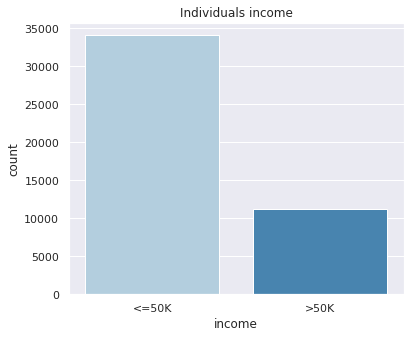

In [4]:
# Bar plot to show the number of individuals making more than $50,000 or less (check Imbalance)
sns.set(style="darkgrid",rc = {'figure.figsize':(6,5)})
bar1 = sns.countplot(x="income", data=df, palette='Blues').set_title('Individuals income');

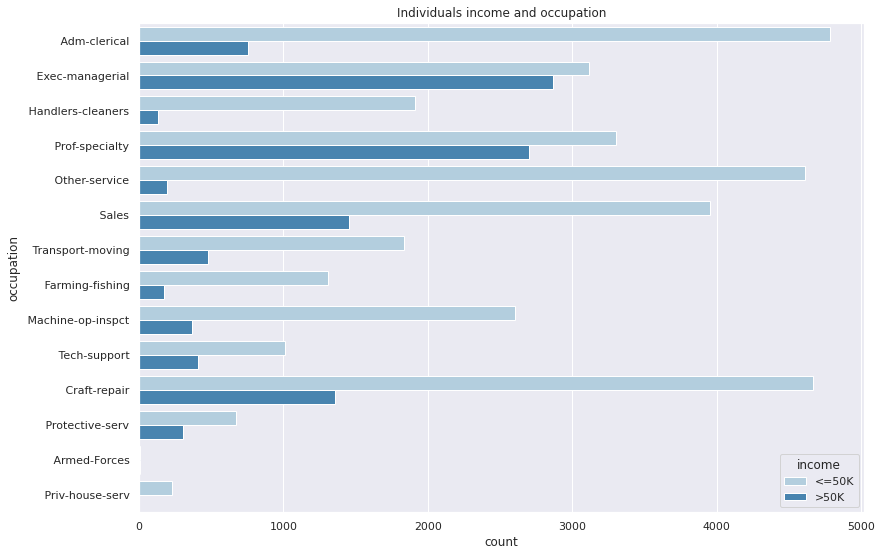

In [5]:
# Bar plot to show the number of individuals income and there occupation
sns.set(style="darkgrid",rc = {'figure.figsize':(13,9)})
sns.countplot(y='occupation', hue='income', data = df, palette='Blues').set_title('Individuals income and occupation');

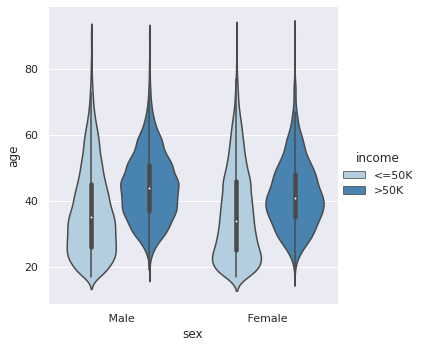

In [6]:
# Violin plot to show the distribution of age based on the sex and income
sns.set(style="darkgrid",rc = {'figure.figsize':(9,10)})
sns.catplot(data=df, kind="violin",x="sex", y="age", hue="income",palette='Blues');

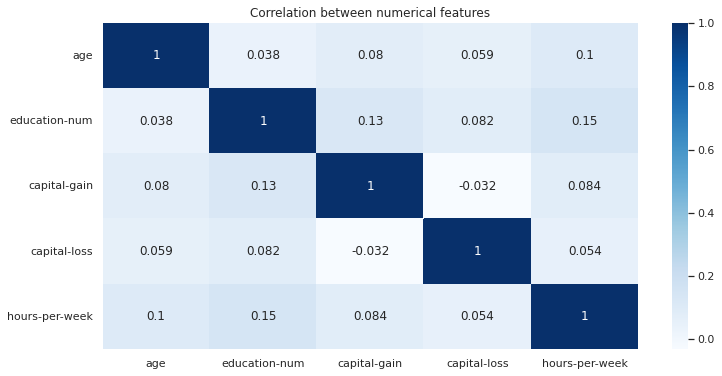

In [7]:
# Heatmap of correlation between only the numerical variables
num = df.select_dtypes(include=['int','float'])
corr = num.corr()
sns.set(style="darkgrid",rc = {'figure.figsize':(12,6)})
sns.heatmap(corr,cmap='Blues',annot=True).set_title('Correlation between numerical features');

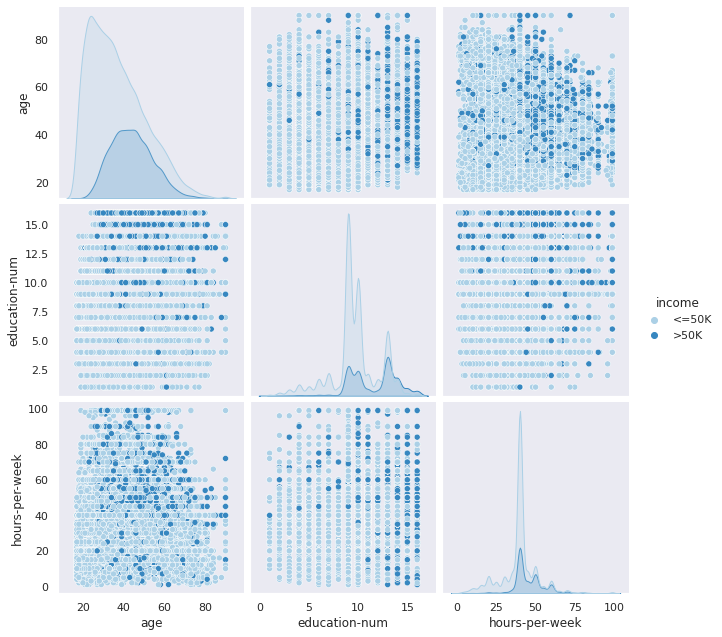

In [8]:
# Plot numerical variables
sns.set(style="dark",rc = {'figure.figsize':(10,6)})
sns.pairplot(df[['age','education-num','hours-per-week','income']],hue="income", dropna=True,palette="Blues",height=3);

---

# Preparing the Data

# 1.Dealing with numerical data

<h1><center>
 Transforming Skewed Continuous Features 
</center></h1>

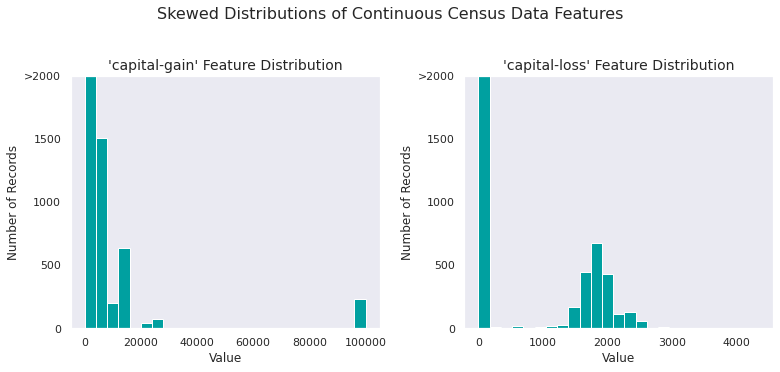

In [9]:
# Distribution of continuous variables
vs.distribution(df)

In [10]:
# defining the dependent(income) and independent(features) variables
income = df['income']
features = df.iloc[:, 0:13]

In [11]:
# Log-transform the continuous variables
skewed = ['capital-gain', 'capital-loss']
features[skewed] = df[skewed].apply(lambda x: np.log(x + 1))

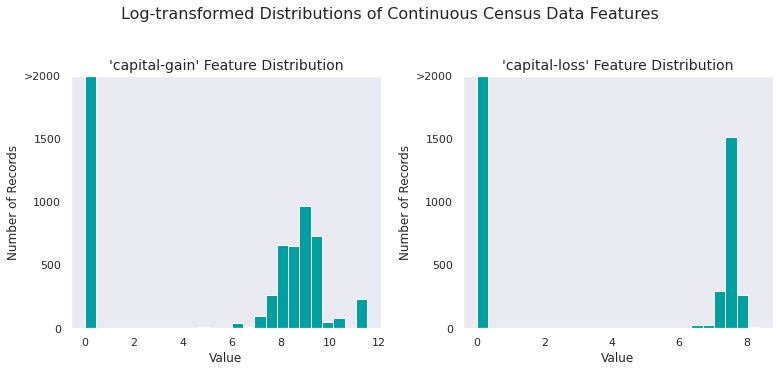

In [12]:
vs.distribution(features, transformed = True)

<h1><center>
 Normalizing Numerical Features
</center></h1>

In [13]:
# Import sklearn.preprocessing.StandardScaler 
# resource: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

# Initializing a scaler, and then applying it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features[numerical] = scaler.fit_transform(df[numerical])

In [14]:
# show the numerical features after scaling
features.head(1)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


# 2.Dealing with categorical data

In [15]:
# One-hot encoding the categorical features
features = pd.get_dummies(features)
income = income.apply(lambda x: 1 if x == '>50K' else 0)

print("{} number of features after one-hot encoding.".format(len(list(features.columns))))

103 number of features after one-hot encoding.


# 3.Splitting the data

In [16]:
# split the data into training and test sets, 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


---------------

#  Modeling

<h1><center>
  Naive Predict
</center></h1>

**Accuracy**: measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions.

**Precision**:`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)**:`[True Positives/(True Positives + False Negatives)]`

**F-beta score**: 
$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In [17]:
accuracy = (np.sum(income)) / ((np.sum(income)) + float(((income.count()) - np.sum(income))))
recall = np.sum(income) / float((np.sum(income) + 0))
precision = np.sum(income) / float(((np.sum(income) + ((income.count()) - np.sum(income)))))

beta = 0.5
fscore = (1+ beta**2) * (precision * recall) / ((beta ** 2 * precision) + recall)

print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


<h1><center>
 Machine Learning Models
</center></h1>

In [18]:
# Function to calculate 'Accuracy' & 'F-score' after training and predicting 
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    
    results = {}
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    predictions_test = learner.predict(X_test)
   
    results['Accuracy'] = accuracy_score(y_test, predictions_test)
    results['F-score'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    print("Finish trained {} on {} samples.".format(learner.__class__.__name__, sample_size))
    return results 

### 1.Logistic Regression

In [19]:
# Fit the Logistic Regression model
results1={}
results1= train_predict(LogisticRegression(random_state=40),
                        int(0.10*len(X_train)),X_train, y_train, X_test, y_test)

Finish trained LogisticRegression on 3617 samples.


In [20]:
print("The accuracy score: {}.".format(results1['Accuracy']))
print("The F-score: {}.".format(results1['F-score']))

The accuracy score: 0.8369264787175235.
The F-score: 0.6745811605458782.


###  2.Decision Tree 

In [21]:
# Fit the Decision Tree Classifier
results2={}
results2=train_predict(tree.DecisionTreeClassifier(random_state=40),
                       int(0.10*len(X_train)),X_train, y_train, X_test, y_test)

Finish trained DecisionTreeClassifier on 3617 samples.


In [22]:
print("The accuracy score: {}.".format(results2['Accuracy']))
print("The F-score: {}.".format(results2['F-score']))

The accuracy score: 0.8024322830292979.
The F-score: 0.5956264879640244.


### 3.Random Forest

In [23]:
# Fit the Random Forest Classifier
results3={}
results3=train_predict(RandomForestClassifier(random_state=40),
                       int(0.10*len(X_train)),X_train, y_train, X_test, y_test)

Finish trained RandomForestClassifier on 3617 samples.


In [24]:
print("The accuracy score: {}.".format(results3['Accuracy']))
print("The F-score: {}.".format(results3['F-score']))

The accuracy score: 0.831951354339414.
The F-score: 0.660781166399144.


### 3.Support Vector Classifier (SVC)

In [25]:
# Fit the SVC model
results4={}
results4=train_predict(SVC(random_state=40),int(0.10*len(X_train)),
                       X_train, y_train, X_test, y_test)

Finish trained SVC on 3617 samples.


In [26]:
print("The accuracy score: {}.".format(results4['Accuracy']))
print("The F-score: {}.".format(results4['F-score']))

The accuracy score: 0.8226644555002764.
The F-score: 0.6408459676391897.


# Comparison

In [27]:
# Create 4 dataframes containig the results
results1_items = results1.items()
results1_list = list(results1_items)
results1_df = pd.DataFrame(results1_list)
results1_df['Model_Name']='LogisticRegression','LogisticRegression'

results2_items = results2.items()
results2_list = list(results2_items)
results2_df = pd.DataFrame(results2_list)
results2_df['Model_Name']='DecisionTreeClassifier','DecisionTreeClassifier'

results3_items = results3.items()
results3_list = list(results3_items)
results3_df = pd.DataFrame(results3_list)
results3_df['Model_Name']='RandomForestClassifier','RandomForestClassifier'

results4_items = results4.items()
results4_list = list(results4_items)
results4_df = pd.DataFrame(results4_list)
results4_df['Model_Name']='SVC','SVC'

In [28]:
# Merge the tables
results=pd.concat([results1_df,results2_df,results3_df,results4_df])
results=results.rename({results.columns[0]: 'Type', results.columns[1]: 'Value'}, axis=1)
results.reset_index(inplace=True)
results=results.drop(['index'], axis=1)
results

,Type,Value,Model_Name
0,Accuracy,0.836926,LogisticRegression
1,F-score,0.674581,LogisticRegression
2,Accuracy,0.802432,DecisionTreeClassifier
3,F-score,0.595626,DecisionTreeClassifier
4,Accuracy,0.831951,RandomForestClassifier
5,F-score,0.660781,RandomForestClassifier
6,Accuracy,0.822664,SVC
7,F-score,0.640846,SVC


In [29]:
 met=results.loc[(results["Type"]== 'Accuracy') | (results["Type"]== 'F-score')]

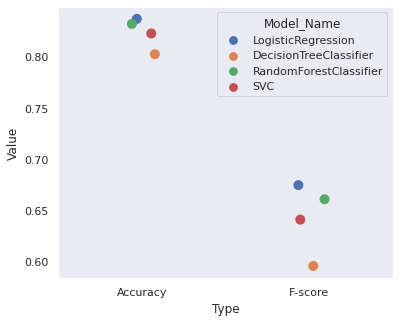

In [30]:
sns.set(style="dark",rc = {'figure.figsize':(6,5)})
sns.stripplot(x="Type", y="Value",hue="Model_Name", data=met,size=10);